In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

# Load and preprocess MNIST data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize pixel values between 0 and 1
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Reshape images to a flattened format
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

data_shape = 784  # shape of the data (28x28=784)
latent_dim = 2  # dimension of the latent space
batch_size = 128  # batch size for training

In [2]:
# Create encoder
inputs = tf.keras.Input(shape=data_shape)
x = tf.keras.layers.Dense(256, activation='relu')(inputs)
x = tf.keras.layers.Dense(256, activation='relu')(x)

# Mean and standard deviation outputs for the approximate posterior qφ(z|x)
z_mean = tf.keras.layers.Dense(latent_dim)(x)
z_log_var = tf.keras.layers.Dense(latent_dim)(x)

# Reparameterization trick for sampling from the distribution
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.keras.backend.random_normal(shape=(tf.shape(z_mean)[0], latent_dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = tf.keras.layers.Lambda(sampling)([z_mean, z_log_var])

encoder = tf.keras.Model(inputs, [z_mean, z_log_var, z], name='encoder')

# Create decoder
latent_inputs = tf.keras.Input(shape=(latent_dim,), name='z_sampling')
x = tf.keras.layers.Dense(256, activation='relu')(latent_inputs)
x = tf.keras.layers.Dense(256, activation='relu')(x)

# Output only the mean of pθ(x|z)
outputs = tf.keras.layers.Dense(data_shape, activation='sigmoid')(x)

# Implement standard deviation as a trainable variable of the model
# Single floating-point trainable variable for the decoder standard deviation
decoder_stddev = tf.Variable(tf.ones(shape=(data_shape,), dtype=tf.float32), name='decoder_stddev')
decoded_with_stddev = tf.keras.layers.Lambda(lambda x: x[0] * x[1])([outputs, decoder_stddev])

decoder = tf.keras.Model(latent_inputs, decoded_with_stddev, name='decoder')

# Create VAE
outputs = decoder(encoder(inputs)[2])
vae = tf.keras.Model(inputs, outputs, name='vae')

The following Variables were used a Lambda layer's call (lambda_1), but
are not present in its tracked objects:
  <tf.Variable 'decoder_stddev:0' shape=(784,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


In [3]:
# Define the loss function
reconstruction_loss = tf.keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= data_shape

# Include the standard deviation term in the reconstruction loss
reconstruction_loss += 0.5 * tf.reduce_sum(tf.square(outputs - inputs) / tf.square(decoder_stddev) + tf.math.log(tf.square(decoder_stddev)))

kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
kl_loss = tf.reduce_sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
vae.compile(optimizer=optimizer)

In [4]:
# Train the VAE and collect loss values
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = vae.fit(
    x_train,
    epochs=100,
    batch_size=batch_size,
    validation_data=(x_test, None),
    callbacks=[early_stopping]
)

Epoch 1/100
469/469 [==============================] - 5s 8ms/step - loss: 3117.9460 - val_loss: 2512.9578
Epoch 2/100
469/469 [==============================] - 4s 8ms/step - loss: 2451.6709 - val_loss: 2348.0911
Epoch 3/100
469/469 [==============================] - 4s 9ms/step - loss: 2340.3262 - val_loss: 2275.4473
Epoch 4/100
469/469 [==============================] - 4s 9ms/step - loss: 2268.5718 - val_loss: 2216.5686
Epoch 5/100
469/469 [==============================] - 4s 8ms/step - loss: 2209.6548 - val_loss: 2172.5452
Epoch 6/100
469/469 [==============================] - 4s 8ms/step - loss: 2170.1680 - val_loss: 2142.9668
Epoch 7/100
469/469 [==============================] - 4s 9ms/step - loss: 2131.4624 - val_loss: 2113.4692
Epoch 8/100
469/469 [==============================] - 4s 9ms/step - loss: 2109.5481 - val_loss: 2083.8213
Epoch 9/100
469/469 [==============================] - 4s 9ms/step - loss: 2077.9705 - val_loss: 2064.2974
Epoch 10/100
469/469 [===============

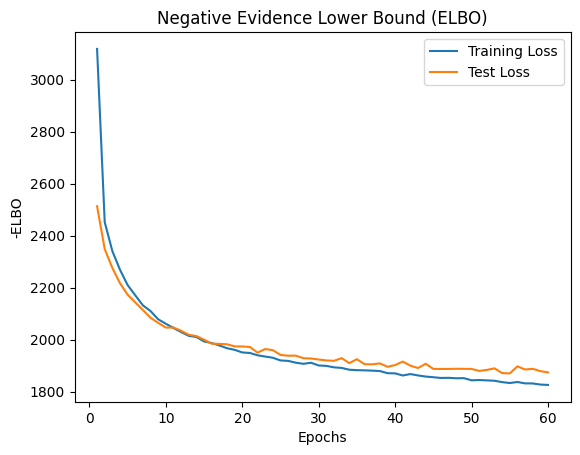

In [5]:
""" Plotting the loss curve (test set), i.e., epoch vs. −LELBO"""

# Extract loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot loss curve
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('-ELBO')
plt.title('Negative Evidence Lower Bound (ELBO)')
plt.legend()
plt.show()

79/79 [==============================] - 0s 2ms/step


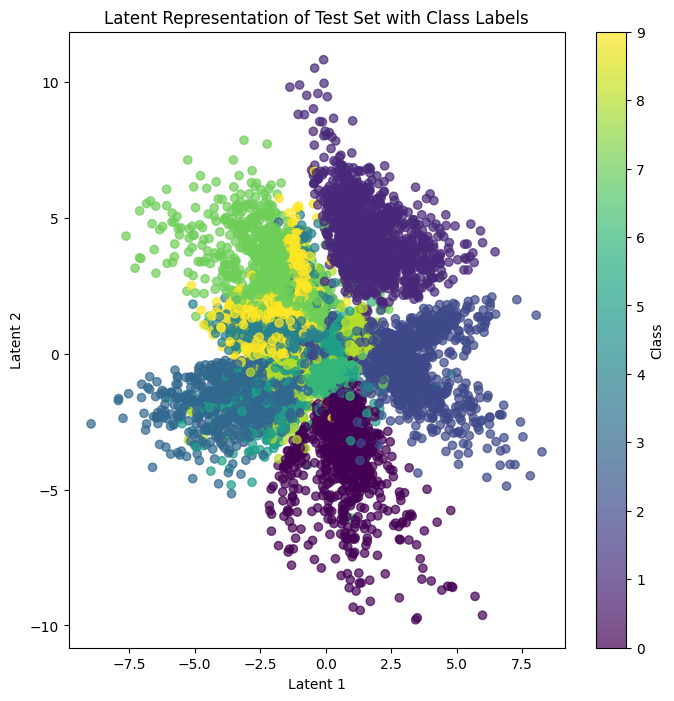

In [6]:
# Encode the test set
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)[2]

# Create a DataFrame for better organization
latent_df = pd.DataFrame({
    'Latent 1': x_test_encoded[:, 0],
    'Latent 2': x_test_encoded[:, 1],
    'Class': y_test
})

# Scatter plot of the latent representation with different colors for each class
plt.figure(figsize=(8, 8))
scatter = plt.scatter(latent_df['Latent 1'], latent_df['Latent 2'], c=latent_df['Class'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Class')
plt.title('Latent Representation of Test Set with Class Labels')
plt.xlabel('Latent 1')
plt.ylabel('Latent 2')
plt.show()


313/313 [==============================] - 1s 2ms/step


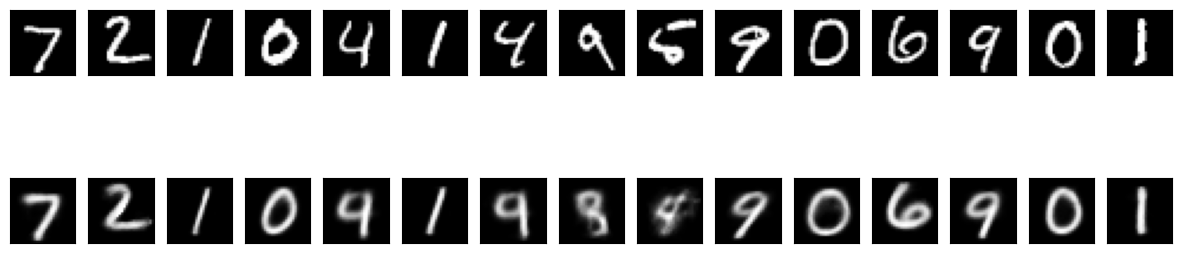

In [7]:
# Generate reconstructed images
reconstructed_images = vae.predict(x_test)

# Plot original and reconstructed images
n = 15  # Number of digits to display
plt.figure(figsize=(15, 4))

for i in range(n):
    # Original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #ax.set_title('Original')

    # Reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #ax.set_title('Reconstructed')

plt.show()


1/1 [==============================] - 0s 50ms/step


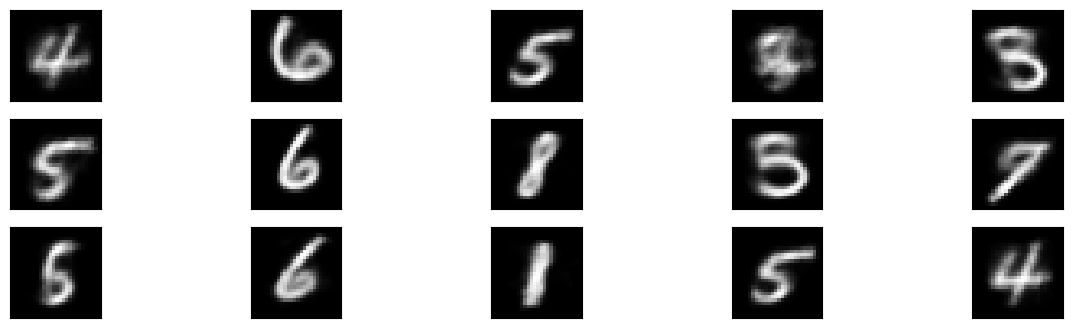

In [8]:
# Generate samples from the prior distribution
random_samples = np.random.normal(size=(15, latent_dim))

# Decode random samples
generated_images = decoder.predict(random_samples)

# Plot generated images
plt.figure(figsize=(15, 4))

for i in range(15):
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(generated_images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()
